## Importing

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, BatchNormalization, Dropout #When added to a model, max pooling reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer.
from tensorflow.keras.models import Sequentialfrom tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from shutil import copyfile
from sklearn.metrics import accuracy_score, classification_report

## Preprocessing

In [3]:
import os
import csv
import numpy as np
import pandas as pd
import os
import imageio
import glob
import pathlib
path = 'your_path'

with open('train_final.csv', 'w', newline='') as csvfile:
    files = []
    for r, d, f in os.walk(path):
        for _file in f:
            if '.jpg' in _file:
                files.append(_file)

    header = ["image_id", "label"]
    # Create a writer from csv module
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(i for i in header)

    for f in files:  # find type of file
        t = f[0:-4]

        if "100" in t:
            t = 1
        elif "200" in t:
            t = 2
        elif "300" in t:
            t = 3
        elif "400" in t:
            t = 4
        elif "500" in t:
            t = 5
        elif "600" in t:
            t = 6

        writer.writerow([f, t]) 

In [56]:
train = pd.read_csv('your_path.csv')
print(train)

              image_id  label
0      500_2404562.jpg      5
1      600_2403977.jpg      6
2      100_2353270.jpg      1
3      300_2405064.jpg      3
4      100_2349228.jpg      1
...                ...    ...
19373  100_2349231.jpg      1
19374  100_2346102.jpg      1
19375  100_2352177.jpg      1
19376  300_2406574.jpg      3
19377  100_2353269.jpg      1

[19378 rows x 2 columns]


In [57]:
from PIL import Image
import cv2
IMG_DIR = '//Users/ozgecanyuzer/Documents/Classes/Ling_412/Preprocessing/Cropped Images/train'
temp = []
for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)
        if img_array is not None:
            img_array = (img_array.flatten())
            img_array = img_array.astype(float)
            temp.append(img_array)

print(temp)
train_x = np.stack(temp)

[array([93., 93., 93., ..., 81., 81., 81.]), array([91., 91., 91., ..., 82., 82., 82.]), array([ 82.,  86.,  91., ..., 103., 103., 103.]), array([66., 69., 73., ..., 95., 95., 95.]), array([ 70.,  74.,  81., ..., 115., 115., 115.]), array([106., 106., 119., ..., 103., 103., 103.]), array([ 70.,  72.,  73., ..., 112., 111., 110.]), array([114., 117., 105., ..., 108., 108., 108.]), array([58., 59., 60., ..., 92., 91., 91.]), array([76., 80., 85., ..., 86., 86., 86.]), array([ 72.,  76.,  81., ..., 114., 114., 114.]), array([ 71.,  78.,  88., ..., 107., 107., 107.]), array([78., 81., 87., ..., 93., 93., 92.]), array([39., 38., 36., ..., 76., 76., 76.]), array([64., 67., 71., ..., 96., 96., 96.]), array([ 85.,  89.,  93., ..., 107., 107., 106.]), array([ 99., 100., 102., ...,  93.,  93.,  93.]), array([68., 68., 67., ..., 95., 95., 95.]), array([ 85.,  88.,  93., ..., 105., 105., 105.]), array([90., 91., 93., ..., 84., 84., 84.]), array([68., 68., 67., ..., 95., 95., 95.]), array([87., 90.

In [58]:
train_y = keras.utils.np_utils.to_categorical(train.label.values)

In [59]:
print(train_x.shape)

(19378, 19800)


In [60]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.20,random_state=4)

In [61]:
print(shape(x_train))

(15502, 19800)


In [62]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

In [63]:
x_train = x_train / 255 #Normalizing the images
x_test = x_test / 255

In [76]:
print(shape(y_train))

(15502, 7)


In [74]:
train_x_temp = x_train.reshape(-1, 180, 110, 1)
test_x_temp = x_test.reshape(-1, 180, 110, 1)
print(shape(test_x_temp))

(3876, 180, 110, 1)


## Model Training

In [68]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', min_delta=0.001, # minimium amount of change to count as an improvement
                                patience=5, # how many epochs to wait before stopping
                                restore_best_weights=True
                              ) 
strategy = tf.distribute.MirroredStrategy() #Distrubitues the training across multiple GPU's

with strategy.scope():
    model = Sequential([ Conv2D(128 , (3,3)  , padding = 'same' , activation = 'relu' , input_shape = (180,110,1)),
                         MaxPool2D(2,2), 
                         Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         MaxPool2D(2,2),
                         Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
                         MaxPool2D(2,2),
                        #Flatten reduces the dimensions of the layer. Literally flattens it. Why we use it : A flatten operation on a tensor reshapes the tensor to have the shape that is equal to the number of elements contained in tensor non including the batch dimension.
                         Flatten(),#Dense creates a fully-connected hidden layer with  512 nodes or 24 nodes like the one below
                         Dense(units = 512 , activation = 'relu'),                         Dropout(0.2),#The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.
                         Dense(units = 7 , activation = 'softmax')
                       ]) #The model first learns 128 filters, then 64, 64 and finally 7 filters. The padding is same, meaning the output volume size matches the input volume size.
                       #use_bias isn't used.
    
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy']) #Loss is the most important
                        
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 180, 110, 128)     1280      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 55, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 90, 55, 64)        73792     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 90, 55, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 27, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 27, 25)        14425     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 13, 25)       

In [77]:
trained_model = model.fit(train_x_temp, y_train, epochs=10, validation_data=(test_x_temp, y_test), callbacks = [early_stopping])


Train on 15502 samples, validate on 3876 samples
Epoch 1/10
15502/15502 [==============================] - 2604s 168ms/sample - loss: 0.1939 - accuracy: 0.9417 - val_loss: 0.0652 - val_accuracy: 0.9915
Epoch 2/10
15502/15502 [==============================] - 2554s 165ms/sample - loss: 0.0614 - accuracy: 0.9889 - val_loss: 0.0519 - val_accuracy: 0.9928
Epoch 3/10
15502/15502 [==============================] - 2553s 165ms/sample - loss: 0.0496 - accuracy: 0.9904 - val_loss: 0.0393 - val_accuracy: 0.9943
Epoch 4/10
15502/15502 [==============================] - 2535s 164ms/sample - loss: 0.0464 - accuracy: 0.9913 - val_loss: 0.0453 - val_accuracy: 0.9951
Epoch 5/10
15502/15502 [==============================] - 2534s 163ms/sample - loss: 0.0407 - accuracy: 0.9915 - val_loss: 0.0349 - val_accuracy: 0.9948
Epoch 6/10
15502/15502 [==============================] - 2547s 164ms/sample - loss: 0.0417 - accuracy: 0.9907 - val_loss: 0.0432 - val_accuracy: 0.9920
Epoch 7/10
15502/15502 [=========

## Model Evaluation

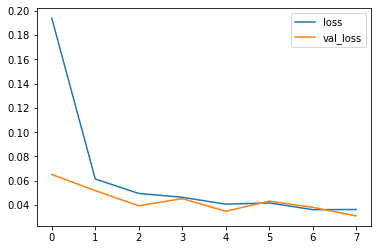

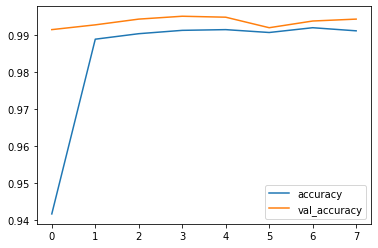

In [78]:
history_df = pd.DataFrame(trained_model.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [116]:
model.save("/Users/ozgecanyuzer/Documents/Classes/Ling_412/Coding/sign_language_generation.h1")

INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /replica:0/task:0/device:CPU:0 then broadcast to ('/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Assets written to: /Users/ozgecanyuzer/Documents/Classes/Ling_412/Coding/sign_language_generation.h1/assets


In [82]:
model.evaluate(test_x_temp, y_test)

3876/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.039342969335728326, 0.994324]

In [84]:
y_pred = np.argmax(model.predict(test_x_temp),axis = 1) 

In [85]:
y_true = np.argmax(y_test, axis =1)

In [87]:
print('Model Accuracy = ', (accuracy_score(y_true, y_pred)*100),"%")

Model Accuracy =  0.9943240454076367 2


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [88]:
print(classification_report(y_true, y_pred))#128, full data 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1603
           2       1.00      1.00      1.00       586
           3       0.99      1.00      0.99       650
           4       0.98      0.97      0.98       311
           5       0.99      0.99      0.99       262
           6       0.99      1.00      0.99       464

    accuracy                           0.99      3876
   macro avg       0.99      0.99      0.99      3876
weighted avg       0.99      0.99      0.99      3876



## Predictions

In [3]:
from tensorflow import keras
model = keras.models.load_model('/Users/ozgecanyuzer/Documents/Classes/Ling_412/Coding/sign_language_generation.h1')

In [16]:
import cv2
CATEGORIES = ["Other","Covered-T", "Flat", "Index", "L", "Middle-Selected", "V/2"]


def prepare(filepath):   
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = np.float32(img_array)
    new_array = cv2.resize(img_array, (180,110))
    return new_array.reshape(-1,180,110, 1)



prediction = model.predict([prepare('/Users/ozgecanyuzer/Downloads/Flat_3.jpg')])
print(prediction)

type(prediction)

i, j = np.where(prediction == 1)
print(CATEGORIES[int(j)])


[[0. 1. 0. 0. 0. 0. 0.]]
Covered-T
